# DATA DOWNLOAD
To start this project, you need an addition data file.

First you should download data from:
https://pan.baidu.com/s/1KFui9zZKjRqzFkCJH5nenw
    
Then unzip it,create a data dir, and put it in data directory

## After you do all that , the following file should be found:

```python
'data/segmented_train_seg_by_word.txt' 
```

And that means you are good to go.

In [31]:
! wc -l data/segmented_train_seg_by_word.txt

20000000 data/segmented_train_seg_by_word.txt


# DATA PROCESS

In [2]:
from utils import ProgressBar
import numpy as np
import collections
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
enline = None
chline = None

sentlength = np.inf

enlines = []
chlines = []
pb = ProgressBar(worksum=10000000)
pb.startjob()
num = 0
with open('data/segmented_train_seg_by_word.txt',encoding="utf-8") as fhdl:
    for line in fhdl:
        num += 1
        if num % 2 == 1:
            enline = line
            continue
        else:
            chline = line
        
        enlinesp = [i.lower() for i in enline.strip("\n").split()]
        chlinesp = [i for i in chline.strip("\n").split()]
        if len(enlinesp) <= sentlength and len(chlinesp) <= sentlength:
            enlines.append(enlinesp)
            chlines.append(chlinesp)
        if (num // 2) % 1000 == 0:
            pb.complete(1000)
            
        #if num // 2 >= 1000000:
        #    break
        

 100.00 % [==================================================>] 10000000/10000000 	 used:108s eta:0 s

In [5]:
enlines[:10]

[['a',
  'pair',
  'of',
  'red',
  '-',
  'crowned',
  'cranes',
  'have',
  'staked',
  'out',
  'their',
  'nesting',
  'territory'],
 ['a',
  'pair',
  'of',
  'crows',
  'had',
  'come',
  'to',
  'nest',
  'on',
  'our',
  'roof',
  'as',
  'if',
  'they',
  'had',
  'come',
  'for',
  'lhamo',
  '.'],
 ['a',
  'couple',
  'of',
  'boys',
  'driving',
  'around',
  'in',
  'daddy',
  "'",
  's',
  'car',
  '.'],
 ['a',
  'pair',
  'of',
  'nines',
  '?',
  'you',
  'pushed',
  'in',
  'with',
  'a',
  'pair',
  'of',
  'nines',
  '?'],
 ['fighting', 'two', 'against', 'one', 'is', 'never', 'ideal', ','],
 ['it',
  "'",
  's',
  'a',
  'neat',
  'one',
  '-',
  'two',
  '.',
  'walker',
  'to',
  'burton',
  '.'],
 ['deuces', 'the', 'winner', '.'],
 ['five',
  'on',
  'one',
  '.',
  'five',
  'on',
  'one',
  '.',
  'yeah',
  ',',
  'not',
  'the',
  'greatest',
  'odds',
  '.'],
 ['an', 'incredibly', 'emotional', 'fight', 'between', '2', 'sisters', '？'],
 ['one', 'against', '500'

In [6]:
chlines[:10]

[['一对', '丹顶鹤', '正', '监视', '着', '它们', '的', '筑巢', '领地'],
 ['一对',
  '乌鸦',
  '飞',
  '到',
  '我们',
  '屋顶',
  '上',
  '的',
  '巢里',
  '，',
  '它们',
  '好像',
  '专门',
  '为拉木',
  '而',
  '来',
  '的',
  '。'],
 ['一对', '乖乖仔', '开着', '老爸', '的', '车子', '。'],
 ['一对', '九', '？', '一对', '九', '你', '就', '全', '下注', '了', '？'],
 ['一对二', '总', '不是', '好事', '，'],
 ['一对二', '，', '沃克', '传给', '波顿', '。'],
 ['一对二', '胜', '。'],
 ['一对', '五', '。', '一对', '五', '。', '胜算', '不大', '啊', '。'],
 ['一对', '五年', '没见', '过', '的', '姐妹', '一场', '激烈', '的', '争吵', '？'],
 ['一对', '五百', '诶', '。']]

In [7]:
len(chlines),len(enlines)

(10000000, 10000000)

In [8]:
chwords = []

for sent in chlines:
    for chword in sent:
        chwords.append(chword)

In [9]:
from collections import Counter

In [10]:
Counter(chwords).most_common(15)

[('。', 7829572),
 ('的', 5689326),
 ('，', 5226407),
 ('我', 3454986),
 ('你', 2687663),
 ('了', 2071109),
 ('？', 1571009),
 ('是', 1485247),
 ('在', 1418398),
 ('他', 1118269),
 ('我们', 899295),
 ('和', 644347),
 ('她', 633832),
 ('不', 627412),
 ('就', 545092)]

In [11]:
def addchar(what2ind,ind2what,char):
    if char in what2ind:
        return 
    ind2what[len(what2ind)] = char
    what2ind[char] = len(what2ind)

In [54]:
ch2ind = {}
ind2ch = {}

specialchars = ['<pad>','<unk>']

for one in specialchars:
    addchar(ch2ind,ind2ch,one)

In [55]:
for word,_ in Counter(chwords).most_common(10000):
    addchar(ch2ind,ind2ch,word)

In [15]:
dat_x_in = []

for chsent in chlines:
    indsent = [ch2ind.get(i,ch2ind['<unk>']) for i in chsent]
    #indsent.append(ch2ind['<eos>'])
    dat_x_in += indsent


In [16]:
print(''.join([ind2ch[i] for i in dat_x_in[:20]]))

一对<unk>正监视着它们的<unk>领地一对<unk>飞到我们屋顶上的<unk>，它们


In [17]:
len(dat_x_in)

109497518

In [18]:
def data_generator(batch_size,cbow):
    'cbow<--|word|-->cbow'
    window = 2 * cbow + 1
    batch_data = []
    
    while True:
        for i in range(len(dat_x_in) - window):
            batch_data.append(dat_x_in[i:i + window])
            if len(batch_data) >= batch_size:
                batch_data = np.asarray(batch_data)
                batch_x = np.concatenate([batch_data[:,:cbow],batch_data[:,-cbow:]],axis=1)
                batch_y = batch_data[:,cbow]
                yield batch_x,batch_y
                batch_data = []

In [19]:
gen = data_generator(128,1)

In [20]:
batch_x,batch_y = gen.__next__()

In [21]:
batch_x.shape ,batch_y.shape

((128, 2), (128,))

# MODEL PART

In [22]:
batch_size = 256
embedding_size = 100
vocabulary_size = len(ind2ch)
cbow = 1
negative_sample_number = 64

In [23]:
import tensorflow as tf
import tflearn
tf.reset_default_graph()
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement = True)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)


In [25]:

tf.reset_default_graph()
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement = True)
config.gpu_options.allow_growth = True
session = tf.Session(config=config)


with tf.device('/gpu:1'):
    x = tf.placeholder(tf.int32, shape=[None,2 * cbow])
    y = tf.placeholder(tf.int32, shape=[None])
    target = tf.expand_dims(y,1)
    learning_rate = tf.placeholder(tf.float32)

    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -0.08, 0.08))
    
    sample_x =  tf.placeholder(tf.int32, shape=[None])
    sample_embedding = tf.nn.embedding_lookup(embeddings, sample_x)
    
    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                     stddev=1.0 / np.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    one_embedding = None
    for i in range(2 * cbow):
        if one_embedding is None:
            one_embedding = tf.nn.embedding_lookup(embeddings, x[:,i])
        else:
            one_embedding += tf.nn.embedding_lookup(embeddings, x[:,i])
    avg_embedding = one_embedding / (2 * cbow)
    
    nce_loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases,
                               labels=target,
                               inputs=avg_embedding,
                               num_sampled=negative_sample_number,
                               num_classes=len(ind2ch)))
    
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(nce_loss)

saver = tf.train.Saver()
saver.restore(session,'./models/word2vec_model')

In [27]:
session.run(tf.global_variables_initializer())

In [28]:
session.run(sample_embedding,feed_dict={
    sample_x:batch_y
}).shape

(128, 100)

In [29]:
cbow

1

In [30]:
losses = []
beginning_lr = 0.1
gen = data_generator(batch_size,cbow)
for one_epoch in range(1,5):
    pb = ProgressBar(worksum=len(dat_x_in))
    pb.startjob()
    for one_batch in range(len(dat_x_in) // batch_size):
        batch_x,batch_y = gen.__next__()
        batch_lr = beginning_lr 
        _,batch_loss = session.run([optimizer,nce_loss],feed_dict={
            x:batch_x,
            y:batch_y,
            learning_rate:batch_lr,
        })
        pb.info = "EPOCH {} batch {} lr {} loss {}".format(one_epoch,one_batch,batch_lr,batch_loss)
        pb.complete(batch_size)
        losses.append(batch_loss)
    print()

EPOCH 1 batch 427723 lr 0.1 loss 3.8539910316467285 100.00 % [=================================================>-] 109497344/109497518 	 used:1415s eta:0 s
EPOCH 2 batch 427723 lr 0.1 loss 3.790839195251465 100.00 % [=================================================>-] 109497344/109497518 	 used:1412s eta:0 s
EPOCH 3 batch 427723 lr 0.1 loss 4.175330638885498 100.00 % [=================================================>-] 109497344/109497518 	 used:1416s eta:0 s
EPOCH 4 batch 427723 lr 0.1 loss 3.8939666748046875 100.00 % [=================================================>-] 109497344/109497518 	 used:1429s eta:0 s


In [32]:
batch_x.shape,batch_y.shape

((256, 2), (256,))

In [33]:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [57]:
word = '海洋'

inputx = ch2ind[word]

embedding_val = session.run(sample_embedding,feed_dict={sample_x:[inputx]})

dis_words = np.matmul(embedding_val,np.transpose(session.run(normalized_embeddings)))

#dis_words

[ind2ch[i] for i in np.argsort(dis_words[0])[::-1][:8]]

['海洋', '海湾', '森林', '土壤', '绘画', '沙漠', '物理学', '文学']

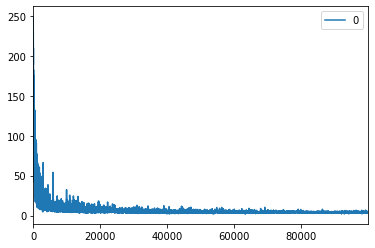

In [42]:
import pandas as pd
%matplotlib inline
pd.DataFrame(losses[:100000]).plot()

In [43]:
saver = tf.train.Saver()

In [44]:
saver.save(session,'models/word2vec_model')

'models/word2vec_model'

In [45]:
! ls -l 'models/word2vec_model.data-00000-of-00001'

-rw-r--r-- 1 root root 16083216 Sep 15 09:32 models/word2vec_model.data-00000-of-00001


# 可视化

In [46]:
words_embedding = session.run(embeddings)

In [47]:
from sklearn.decomposition import PCA

In [48]:
pca = PCA(n_components=2, svd_solver='full')

In [49]:
words_embedding_pca = pca.fit_transform(words_embedding)

In [52]:
#import pypinyin
#zhfont1 = matplotlib.font_manager.FontProperties(fname='/usr/share/fonts/cjkunifonts-ukai/ukai.ttc')
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
 
decisionNode = dict(boxstyle = "sawtooth", fc = "0.8")
leafNode = dict(boxstyle = "round4", fc = "0.8")
arrow_args = dict(arrowstyle = "<-")

In [ ]:
plt.figure(figsize=(25,25))
#'_'.join(pypinyin.lazy_pinyin(ind2ch[i]))
for i in range(400):
    coord = words_embedding_pca
    color = 'red'
    plt.text(coord[i, 0], coord[i, 1],ind2ch[i], bbox=dict(facecolor=color, alpha=0.1),
             fontsize=12)  # fontproperties = ChineseFont1
plt.xlim((np.min(coord[:, 0]), np.max(coord[:, 0])))
plt.ylim((np.min(coord[:, 1]), np.max(coord[:, 1])))
plt.show()